In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import COSData
import Line
from lines_nuc import lines
from scipy.integrate import simps

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
font = 15
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('font', family = 'serif', size = font)

mpl.rcParams['font.size'] = 15
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
percents = np.sort(np.unique(np.concatenate((np.logspace(np.log10(0.0001), np.log10(0.05),10), np.array([-999, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05])))))
percents = percents[ (percents < 0.02)*np.logical_or(percents<0.00019, percents>0.0008) ]
# Variables we are interested in
keys = ['FLUX', 'WAVELENGTH', 'NET', 'EXPTIME', ('GROSS','*', 'EXPTIME'), ('NET','*', 'EXPTIME'), 'Y_UPPER_OUTER', 'Y_LOWER_OUTER'] 

# Wavelength bins for final histograms
wavebin_width = 1 # wavelength bin width [Ang]
wave_bins = np.arange(1000,2400,wavebin_width) # wavelength bins

fitLines = {}
for line in lines:
    fitLines[line] = []
    for percent in percents:
        pre = "./percentsNucleus/perc_"+str(percent)+"/"
        if percent == -999: pre = "./percentsNucleus/percbox_0/"
        exp_pre = [ pre+"ldhv01k1q_", pre+"ldhv01k3q_", pre+"ldhv01k5q_", pre+"ldhv01k7q_",
           pre+"ldhv02xvq_", pre+"ldhv02xzq_", pre+"ldhv02y1q_", pre+"ldhv02y3q_" ]
        
        data = COSData.COSData(exp_pre, keys.copy())
        data.runAll(wave_bins)
        fitLines[line].append(Line.Line(line, lines[line]["wavelength"], data, lines[line]['continuum'], lines[line]['line']))
        fitLines[line][-1].runAll(p0=lines[line]['p0'])
#     pre = "./data/nucleus/"
#     exp_pre = [ pre+"ldhv01k1q_", pre+"ldhv01k3q_", pre+"ldhv01k5q_", pre+"ldhv01k7q_",
#                pre+"ldhv02xvq_", pre+"ldhv02xzq_", pre+"ldhv02y1q_", pre+"ldhv02y3q_" ]
#     data = COSData.COSData(exp_pre, keys.copy())
#     data.runAll(wave_bins)
#     fitLines[line].append(Line.Line(line, lines[line]["wavelength"], data, lines[line]['continuum'], lines[line]['line']))
#     fitLines[line][-1].runAll(p0=lines[line]['p0'])

/tigress/somalwar/Astro_Research/HST_COS2/COSData.py:15: RuntimeWarning: invalid value encountered in true_divide
  self.flux2counts = self.comb_data['NET*EXPTIME']/self.comb_data['FLUX']
/tigress/somalwar/Astro_Research/HST_COS2/COSData.py:16: RuntimeWarning: invalid value encountered in greater
  self.flux2counts[np.logical_or(self.flux2counts > 1e30, np.isnan(self.flux2counts))] = 0


In [3]:
psf = []
for i in range(4):
    psf.append(np.loadtxt('/tigress/somalwar/Astro_Research/HST_COS/data/psfs/aa_CDSFTable_G140L_1280_LP'+str(i+1)+'.dat'))

integral = {}
for line in fitLines:
    waveind = (np.argmin(np.abs(psf[0][0]-fitLines[line][0].wavelength)))
    integral[line] = []
    for di, data in enumerate(fitLines[line][0].data.bindata):
        integral[line].append([])
        for width in np.arange(20, 70, 3):
            psfi = fitLines[line][0].data.fppos[di]-1
            #width = (np.median(data['Y_UPPER_OUTER'] - data['Y_LOWER_OUTER']))
            bounds = [int((len(psf[psfi][1:, waveind])-width)/2), int((len(psf[psfi][1:, waveind])+width)/2)]
            integral[line][-1].append(simps(psf[psfi][1+bounds[0]:1+bounds[1], waveind]))
    integral[line] = (np.arange(20, 70, 3), np.average(integral[line], weights=fitLines[line][0].data.exp, axis=0))

## Plots of flux under each line

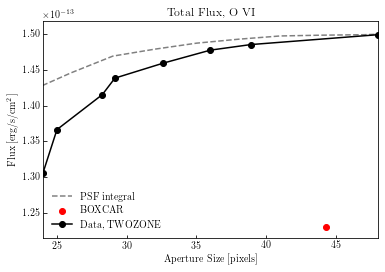

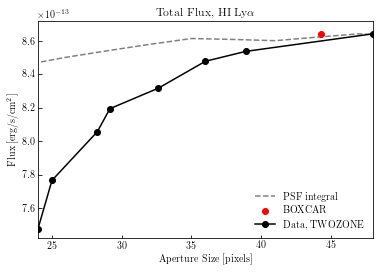

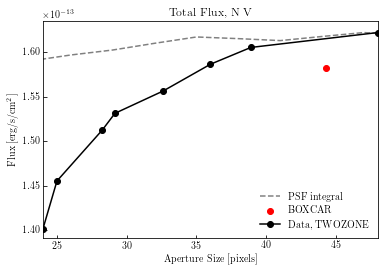

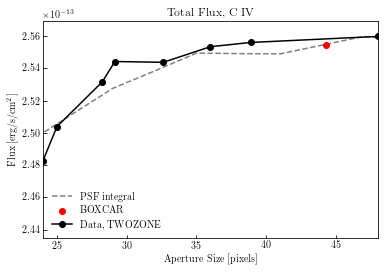

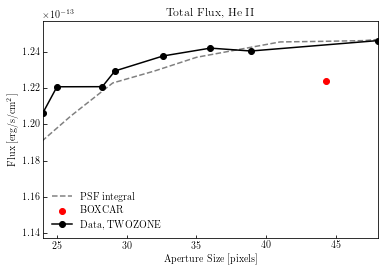

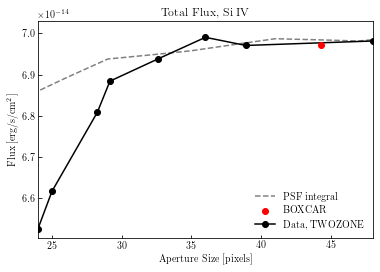

In [4]:
for line in lines:
    flux, aperture_size = [], []
    for i in range(len(fitLines[line])):
        flux.append(np.trapz(fitLines[line][i].data.comb_data['FLUX'][fitLines[line][i].line_ind], fitLines[line][i].data.wave_cen[fitLines[line][i].line_ind]))
        aperture_size.append(np.median(fitLines[line][i].data.comb_data['Y_UPPER_OUTER']-fitLines[line][i].data.comb_data['Y_LOWER_OUTER']))
        
    fig, ax = plt.subplots(1)
    ax.errorbar(aperture_size[1:], flux[1:], label="Data, TWOZONE", fmt='ko-', zorder=10)
    ax.scatter([aperture_size[0]], [flux[0]], c="red", zorder=15, label="BOXCAR")
    ax.plot(integral[line][0], integral[line][1]/integral[line][1][np.argmin(np.abs(aperture_size[1]-integral[line][0]))]*flux[1], label="PSF integral", c="grey", ls="--")
    ax.set_xlabel("Aperture Size [pixels]")
    ax.set_ylabel("Flux [erg/s/cm$^2$]")
    ax.set_title("Total Flux, " + line)
    ax.legend(frameon=False)
    ax.set_xlim(min(aperture_size), max(aperture_size))
    plt.show()

## Plots of flux in continuum

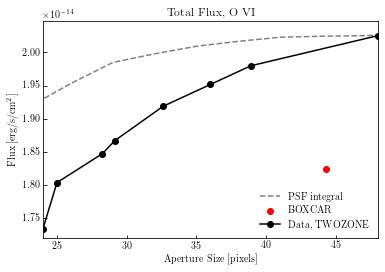

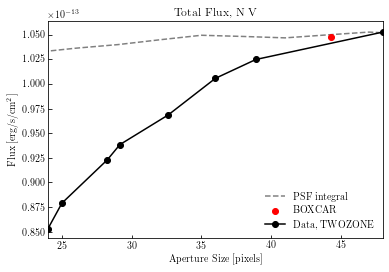

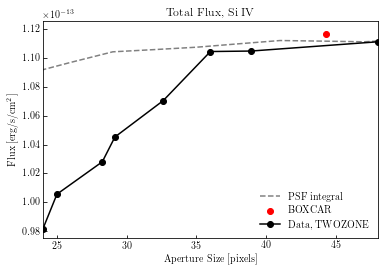

In [5]:
for line in ["O VI", "N V", "Si IV"]:
    flux, aperture_size = [], []
    for i in range(len(fitLines[line])):
        flux.append(simps(fitLines[line][i].data.comb_data['FLUX'][fitLines[line][i].cont_ind[0]], fitLines[line][i].data.wave_cen[fitLines[line][i].cont_ind[0]]))
        aperture_size.append(np.median(fitLines[line][i].data.comb_data['Y_UPPER_OUTER']-fitLines[line][i].data.comb_data['Y_LOWER_OUTER']))
        
    fig, ax = plt.subplots(1)
    ax.errorbar(aperture_size[1:], flux[1:], label="Data, TWOZONE", fmt='ko-')
    ax.scatter([aperture_size[0]], [flux[0]], c="red", zorder=10, label="BOXCAR")
    ax.plot(integral[line][0], integral[line][1]/integral[line][1][np.argmin(np.abs(aperture_size[1]-integral[line][0]))]*flux[1], label="PSF integral", c="grey", ls="--")
    ax.set_xlabel("Aperture Size [pixels]")
    ax.set_ylabel("Flux [erg/s/cm$^2$]")
    ax.set_title("Total Flux, " + line)
    ax.legend(frameon=False)
    ax.set_xlim(min(aperture_size), max(aperture_size))
    plt.show()

In [ ]:
# Plot line ratios as a function of aperture size
ratios = [('O VI', 'N V'), ('O VI', 'C IV'), ('N V', 'C IV')]
for r in ratios:
    flux1, flux2, aperture_size = [], [], []
    for i in range(len(fitLines[r[0]])):
        flux1.append(simps(fitLines[r[0]][i].data.comb_data['FLUX'][fitLines[r[0]][i].line_ind], fitLines[r[0]][i].data.wave_cen[fitLines[r[0]][i].line_ind]))
        flux2.append(simps(fitLines[r[1]][i].data.comb_data['FLUX'][fitLines[r[1]][i].line_ind], fitLines[r[1]][i].data.wave_cen[fitLines[r[1]][i].line_ind]))
        aperture_size.append(np.median(fitLines[r[0]][i].data.comb_data['Y_UPPER_OUTER']-fitLines[r[0]][i].data.comb_data['Y_LOWER_OUTER']))
    flux1, flux2, aperture_size = np.array(flux1), np.array(flux2), np.array(aperture_size)
    fig, ax = plt.subplots(1)
    print(ax)
    ax.errorbar(aperture_size, flux1/flux2, label="Data", fmt='ko-', zorder=10)
    ax.set_xlabel("Aperture Size [pixels]")
    ax.set_ylabel(r[0]+"/"+r[1]);
    ax.set_title("Flux Ratio, " + r[0]+"/"+r[1]);
    ax.legend(frameon=False)
    plt.show()